In [1]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap
from models import HD_cell_L1, PC_cell_L2

#for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
import pycircstat.descriptive as cd

from data_utils import (
    load_pos_mat, 
    load_running_gaps_mat,
    load_spikes_mrl_mat,
    compute_smoothed_speed, 
    compute_smoothed_movement_direction, 
)

from data_analysis_utils import (
    active_scanning_behavioural, 
)
from plotting_utils import (
    plot_circular_histogram,
    plot_expected_theta_sweep,  
    plot_circular_histogram_with_values, 
    plot_paired_boxplot, 
    hexagon_vertices_and_plot, 
)
from CircularLinearReg.core import (
    circular_mean_resultant_vector_length, 
)
from scipy.signal import find_peaks

import os

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

/Users/changminyu/miniconda3/envs/cyu_arm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simulate_honeycomb_movement(
    total_time=1, 
    dt=0.01, 
    move_prob=0.95, 
    drift_factor=0.0, 
    velocity=0.5, 
    rotation_speed=np.pi / 50,
    stick_length=0.2,
    goal_loc=[0, 0]
):
    
    env_size = 1.0
    time_steps = int(total_time / dt)

    pos_A = np.array([env_size / 2, env_size / 2])
    angle = 0
    pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])
    move_angle = np.random.uniform(-np.pi, np.pi)

    A_trajectory = []   
    B_trajectory = []
    head_directions = []
    rotation_phases = []
    rotation_direction_log = []
    time_list = []
    breakTimepoints = []  # Initialise list


    step_count = 0
    current_time = 0
    just_rotated = False  # New flag to prevent back-to-back rotations

    while step_count < time_steps:
        if (np.random.rand() < move_prob and not just_rotated) or just_rotated:
            
            move_angle = (drift_factor * move_angle) + ((1 - drift_factor) * np.random.uniform(-np.pi, np.pi))
            step_size = velocity * dt
            new_pos_A = pos_A + step_size * np.array([np.cos(move_angle), np.sin(move_angle)])
            new_pos_A = np.clip(new_pos_A, 0, env_size)
            pos_A = new_pos_A
            pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

            A_trajectory.append(pos_A.copy())
            B_trajectory.append(pos_B.copy())
            head_directions.append(angle)
            rotation_phases.append(False)
            rotation_direction_log.append(0)
            time_list.append(current_time)

            step_count += 1
            current_time += dt
            just_rotated = False  # Reset flag after movement
        else:
            # Randomly choose rotation direction: +1 (CW) or -1 (CCW)
            direction_flag = np.random.choice([1, -1])
            rotation_duration = int(np.random.uniform(0.3, 1.0) / dt)

            for _ in range(min(rotation_duration, time_steps - step_count)):
                angle -= direction_flag * rotation_speed  # CW = -rotation
                angle = (angle + np.pi) % (2 * np.pi) - np.pi
                pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

                # Check alignment with goal direction
                vec_to_goal = goal_loc - pos_A
                dir_to_goal = np.arctan2(vec_to_goal[1], vec_to_goal[0])
                angle_diff = ((angle - dir_to_goal + np.pi) % (2 * np.pi)) - np.pi  # Wrap to [-π, π]

                # if np.abs(angle_diff) < np.deg2rad(10):  # e.g. 5° threshold
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                # if (np.abs(angle_diff) > np.deg2rad(170)):
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                A_trajectory.append((pos_A.copy()+pos_B.copy())/2)
                B_trajectory.append(pos_B.copy())
                head_directions.append(angle)
                rotation_phases.append(True)
                rotation_direction_log.append(direction_flag)
                time_list.append(current_time)

                step_count += 1
                current_time += dt
                if step_count >= time_steps:
                    break
                
            just_rotated = True  # Mark that a rotation just occurred

    A_trajectory = np.array(A_trajectory)
    B_trajectory = np.array(B_trajectory)
    head_directions = np.array(head_directions)
    rotation_phases = np.array(rotation_phases)
    rotation_direction_log = np.array(rotation_direction_log)
    time_original = np.array(time_list)

    displacement = np.linalg.norm(np.diff(B_trajectory, axis=0), axis=1)
    speeds = np.concatenate(([0], displacement / dt))

    dt_new = 0.001
    time_upsampled = np.arange(0, time_original[-1] + dt_new, dt_new)

    interp_A_x = interp1d(time_original, A_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_A_y = interp1d(time_original, A_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_B_x = interp1d(time_original, B_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_B_y = interp1d(time_original, B_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_head_dir = interp1d(time_original, head_directions, kind='linear', fill_value="extrapolate")
    interp_speeds = interp1d(time_original, speeds, kind='linear', fill_value="extrapolate")

    # Interpolate all trajectories and parameters
    A_trajectory_upsampled = np.vstack((interp_A_x(time_upsampled), interp_A_y(time_upsampled))).T
    B_trajectory_upsampled = np.vstack((interp_B_x(time_upsampled), interp_B_y(time_upsampled))).T
    head_directions_upsampled = interp_head_dir(time_upsampled)
    speeds_upsampled = interp_speeds(time_upsampled)
    head_directions_upsampled = (head_directions_upsampled + np.pi) % (2 * np.pi) - np.pi

    interp_rotation_phase = interp1d(time_original, rotation_phases, kind='nearest', fill_value="extrapolate")
    rotation_phases_upsampled = interp_rotation_phase(time_upsampled).astype(bool)

    interp_rotation_dir = interp1d(time_original, rotation_direction_log, kind='nearest', fill_value="extrapolate")
    rotation_direction_upsampled = interp_rotation_dir(time_upsampled).astype(int)

    vec_to_goal = goal_loc - B_trajectory_upsampled
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])

    diff = np.diff(B_trajectory_upsampled, axis=0)
    Velocity = np.zeros_like(B_trajectory_upsampled)
    Velocity[:-1, :] = diff
    MVDirection = (np.arctan2(Velocity[:, 1], Velocity[:, 0]) + np.pi) % (2 * np.pi) - np.pi
    
    break_indices = np.searchsorted(time_upsampled, breakTimepoints)

    return (
        A_trajectory_upsampled,
        B_trajectory_upsampled,
        head_directions_upsampled,
        MVDirection,
        Dir2Goal,
        speeds_upsampled,
        rotation_phases_upsampled,
        time_upsampled,
        Velocity,
        rotation_direction_upsampled,
        break_indices
    )

def discontinuous_plot(ax, x, y, threshold=np.pi, label=None, **kwargs):
    """
    Plot y vs x on ax, breaking the line at discontinuities > threshold.
    Only applies 'label' to the first segment to avoid legend duplication.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.abs(np.diff(y))
    breaks = np.where(dy > threshold)[0] + 1
    segments = np.split(np.column_stack([x, y]), breaks)

    for i, seg in enumerate(segments):
        ax.plot(seg[:, 0], seg[:, 1], label=label if i == 0 else None, **kwargs)
        
def get_behavioural_data(
    pos_mat_logdir, 
    running_gaps_logdir, 
    T=None, 
    raw_freq=30000, 
    rat_id=None, 
    session_id=None, 
):

    d_pos = load_pos_mat(pos_mat_logdir)

    pos = d_pos["data"]["hComb"]["dlc_XYsmooth"]
    samples = d_pos["data"]["hComb"]["sample"]  # in sampling frequency
    ts = d_pos["data"]["hComb"]["ts"] # in ms
    hd = d_pos["data"]["hComb"]["dlc_angle"] # in degrees

    timestamps = []
    t_end = 0
    for t_ in ts:
        t_new = t_ - t_[0]  # align to zero
        t_new += t_end      # shift to start at current end
        timestamps.append(t_new)
        t_end = t_new[-1] + 33  # advance by last time + 33 ms
    
    timestamps = np.concatenate(timestamps).flatten()
    
    smooth_window = 1 # roughly 500-600 ms
    md = [
        compute_smoothed_movement_direction(pos[i], samples[i], raw_freq, smooth_window)
        for i in range(len(pos))
    ]
    speed = [
        compute_smoothed_speed(pos[i], samples[i], raw_freq, smooth_window)
        for i in range(len(pos))
    ]

    num_trials = len(pos)

    goal_location = d_pos["goalPosition"][0][0][0]
    frame_size = d_pos["frameSize"]

    ###### concatenate all trials ####
    
    pos_concat = np.concatenate(pos, axis=0)
    md_concat = np.concatenate(md, axis=0)
    hd_concat = np.concatenate(hd, axis=0).flatten()
    #convert to rad
    hd_concat = (np.deg2rad(hd_concat) + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]
    speed_concat = np.concatenate(speed, axis=0)
    
    speed_concat /= np.max(frame_size) * np.pi  

    #resize pos_concat to 0-1 and then  -0.5pi to 0.5 pi
    
    pos_concat_x = (pos_concat[:, 0] - pos_concat[:, 0].min()) / (pos_concat[:, 0].max() - pos_concat[:, 0].min())
    pos_concat_y = (pos_concat[:, 1] - pos_concat[:, 1].min()) / (pos_concat[:, 1].max() - pos_concat[:, 1].min())

    #rescale goal_location
    goal_location_x = (goal_location[0] - pos_concat[:, 0].min()) / (pos_concat[:, 0].max() - pos_concat[:, 0].min())
    goal_location_y = (goal_location[1] - pos_concat[:, 1].min()) / (pos_concat[:, 1].max() - pos_concat[:, 1].min())
    
    #rescale to -0.5pi to 0.5pi
    pos_concat_x = pos_concat_x * np.pi - np.pi / 2
    pos_concat_y = pos_concat_y * np.pi - np.pi / 2
    
    goal_location_x = goal_location_x * np.pi - np.pi / 2
    goal_location_y = goal_location_y * np.pi - np.pi / 2
    
    pos_concat = np.stack([pos_concat_x, pos_concat_y], axis=1)
    
    goal_location = np.array([goal_location_x, goal_location_y])

    
    #now interpolate the data to 1ms a point
    new_dt = 1  # 1 ms
    time_upsampled = np.arange(0, timestamps[-1] + new_dt, new_dt)
    
    # Convert circular variables (in radians) to sine and cosine components
    md_sin = np.sin(md_concat)
    md_cos = np.cos(md_concat)
    hd_sin = np.sin(hd_concat)
    hd_cos = np.cos(hd_concat)

    # Create linear interpolators for each component
    interp_md_sin = interp1d(timestamps, md_sin, kind='linear', fill_value="extrapolate")
    interp_md_cos = interp1d(timestamps, md_cos, kind='linear', fill_value="extrapolate")
    interp_hd_sin = interp1d(timestamps, hd_sin, kind='linear', fill_value="extrapolate")
    interp_hd_cos = interp1d(timestamps, hd_cos, kind='linear', fill_value="extrapolate")    
    
    # Interpolate at upsampled timepoints
    md_interp_sin = interp_md_sin(time_upsampled)
    md_interp_cos = interp_md_cos(time_upsampled)
    hd_interp_sin = interp_hd_sin(time_upsampled)
    hd_interp_cos = interp_hd_cos(time_upsampled)

    # Reconstruct interpolated angles
    md_concat = np.arctan2(md_interp_sin, md_interp_cos)
    hd_concat = np.arctan2(hd_interp_sin, hd_interp_cos)

    # Interpolate other variables as before
    interp_pos_x = interp1d(timestamps, pos_concat[:, 0], kind='linear', fill_value="extrapolate")
    interp_pos_y = interp1d(timestamps, pos_concat[:, 1], kind='linear', fill_value="extrapolate")
    interp_speed = interp1d(timestamps, speed_concat, kind='linear', fill_value="extrapolate")
    interp_ts = interp1d(timestamps, np.arange(len(timestamps)), kind='linear', fill_value="extrapolate")
    # Interpolate all trajectories and parameters
    pos_concat = np.vstack((interp_pos_x(time_upsampled), interp_pos_y(time_upsampled))).T
    speed_concat = interp_speed(time_upsampled)
    timestamps_upsampled = interp_ts(time_upsampled).astype(int)  # Convert to integer indices
    
    
    #calculate Direction to Goal
    vec_to_goal = goal_location - pos_concat
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])
    Dir2Goal = (Dir2Goal + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]
    
    velocity = np.zeros_like(pos_concat)
    velocity[:-1, :] = np.diff(pos_concat, axis=0)  # Calculate velocity as difference in position
    
    #recaluclate movement direction based on velocity  
    md_concat2 = np.arctan2(velocity[:, 1], velocity[:, 0])
    
    trial_types = ["hComb", "openF"]

    angular_speed_threshold_quantile = 0.6
    angular_gaps = 0
    cache_dir = None
    scanning_period_duration_threshold = 800

    d_active_scanning_behavioural = active_scanning_behavioural(
        pos_mat_logdir, 
        running_gaps_logdir, 
        trial_types, 
        angular_speed_threshold_quantile, 
        angular_gaps, 
        cache_dir, 
        rat_id, 
        session_id, 
        scanning_period_duration_threshold, 
    )

    num_trials = len(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"])
    rotation_direction = {}

    for i in range(num_trials):
        num_scanning_periods = len(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i])
        sample_trial = d_pos["data"]["hComb"]["sample"][i][:, 0]
        flag_temp = np.zeros((len(d_pos["data"]["hComb"]["dlc_XYsmooth"][i]),))
        if num_scanning_periods == 0:
            rotation_direction[i] = flag_temp
            continue
        for j in range(num_scanning_periods):
            
            start_sample = float(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i][j][0])
            end_sample = float(d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i][j][1])
            clockwise_flag = d_active_scanning_behavioural["active_scanning"]["start_end_samples"]["hComb"][i][j][2]

            inds = np.where((sample_trial >= start_sample) & (sample_trial <= end_sample))[0]
            flag_temp[inds] = 1 if clockwise_flag == "clockwise" else -1
        
        rotation_direction[i] = flag_temp
    
    #concatenate the rotation direction flags to a long array
    rotation_direction_concat = np.concatenate([rotation_direction[i] for i in rotation_direction])
    
    #interpolate the rotation direction to match the timestamps
    interp_rotation_direction = interp1d(timestamps, rotation_direction_concat, kind='nearest', fill_value="extrapolate")
    rotation_direction_concat = interp_rotation_direction(time_upsampled).astype(int)
    
    
    ######----------------------------------------------    
    if T is not None:
        return {
            "pos": pos_concat[:T],
            "md": md_concat2[:T],
            "hd": hd_concat[:T],
            "speed": speed_concat[:T],
            "goal_location": goal_location,
            "frame_size": frame_size,
            "Dir2Goal": Dir2Goal[:T],
            "velocity": velocity[:T],
            "rotation_direction": rotation_direction_concat[:T],
        }    
    else:    
        return {
            "pos": pos_concat,
            "md": md_concat2,
            "hd": hd_concat,
            "speed": speed_concat,
            "goal_location": goal_location,
            "frame_size": frame_size,
            "Dir2Goal": Dir2Goal,
            "velocity": velocity,
            "rotation_direction": rotation_direction_concat,
        }
    
def get_relativeDir2Goal(Animal_location, Head_direction, goal_loc):
    """
    Compute the relative direction to the goal for each position and head direction.
    
    Parameters:
    - Animal_location_all: Array of animal positions (Nx2).
    - Head_direction_all: Array of head directions (N,).
    - goal_loc: Goal location as a 2D array [x, y].
    
    Returns:
    - relative_angle2goal: Array of relative angles to the goal (N,).
    """

    # Ensure goal_loc is a numpy array
    goal_loc = np.array(goal_loc)

    # Vector from current position to consink
    vec = goal_loc - Animal_location  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    relative_angle2goal = (vec_angle - Head_direction + np.pi) % (2 * np.pi) - np.pi
        
    return relative_angle2goal
    

In [3]:
def getSpike_RelativeDirection(consink_loc, Animal_location, Head_direction, spikes):
    """
    Computes the relative direction (in radians) between the head direction and the vector
    pointing from the current position to a candidate sink location, for timepoints where spikes occurred.

    Returns:
        RelativeDirection (ndarray): Vector of relative angles in radians.
        r (float): Mean vector length.
    """
    # Only retain timepoints where spikes occurred
    mask = spikes > 0
    if not np.any(mask):
        return np.array([]), 0.0  # No spikes -> return r=0

    pos = Animal_location[mask]
    hd = Head_direction[mask]

    # Vector from current position to consink
    vec = consink_loc - pos  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    angle_diff = (vec_angle - hd + np.pi) % (2 * np.pi) - np.pi

    # Mean vector length
    r = cd.resultant_vector_length(angle_diff)

    return angle_diff, r

def get_best_consink_location(consink_x, consink_y, Animal_location_all, Head_direction_all, spikes, top_k=10):
    """
    Perform a grid search over candidate sink locations to find the one that maximises 
    the mean resultant length (MRL), and return the average location of the top K sinks.

    Parameters:
        consink_x (np.ndarray): Candidate sink x-coordinates.
        consink_y (np.ndarray): Candidate sink y-coordinates.
        Animal_location_all (np.ndarray): Animal positions at all timepoints.
        Head_direction_all (np.ndarray): Head directions at all timepoints.
        spikes (np.ndarray): Spike counts at all timepoints.
        top_k (int): Number of top MRLs to average for final sink location.

    Returns:
        mean_sink_loc (np.ndarray): Mean coordinates of top-K sink locations by MRL.
        best_mrl (float): Highest MRL value among all candidates.
        best_RelativeDirection (np.ndarray): Relative direction corresponding to the highest MRL.
        all_mrls (list): All MRL values in grid order.
        all_sinks (list): All sink coordinates in grid order.
    """
    best_mrl = -np.inf
    best_RelativeDirection = None
    all_mrls = []
    all_sinks = []

    for cx in consink_x:
        for cy in consink_y:
            consink_loc = np.array([cx, cy])
            RelativeDirection, mrl_val = getSpike_RelativeDirection(
                consink_loc, Animal_location_all, Head_direction_all, spikes
            )
            all_mrls.append(mrl_val)
            all_sinks.append(consink_loc)

            if mrl_val > best_mrl:
                best_mrl = mrl_val
                best_RelativeDirection = RelativeDirection

    # Convert to arrays for indexing
    all_mrls = np.array(all_mrls)
    all_sinks = np.array(all_sinks)

    # Get indices of top K MRLs
    if len(all_mrls) >= top_k:
        top_indices = np.argsort(all_mrls)[-top_k:]
        mean_sink_loc = np.mean(all_sinks[top_indices], axis=0)
    else:
        mean_sink_loc = np.mean(all_sinks, axis=0)  # fallback if < top_k points

    return mean_sink_loc, best_mrl, best_RelativeDirection


def compute_dwell_normalised_activity(best_RelativeDirection, spikes, num_bins=36):
    
    # Dewell time
    num_bins = 36
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

    bin_indices = np.digitize(best_RelativeDirection, angle_bins) - 1
    # Clip to valid bin range
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)
    dwell_time_per_bin = np.zeros(num_bins)
    spikes_per_bin = np.zeros(num_bins)
    np.add.at(dwell_time_per_bin, bin_indices, 1)
    mask = spikes > 0  # Only consider timepoints with spikes
    np.add.at(spikes_per_bin, bin_indices, spikes[mask])
    activity_per_bin = spikes_per_bin / dwell_time_per_bin
    
    return activity_per_bin, bin_centers



In [4]:
rat_session = {
    3: "25-3-2019", 
    7: "6-12-2019", 
    8: "15-10-2019", 
    9: "10-12-2021", 
    10: "23-11-2021", 
}

for rat_id in [3, 7, 8, 9]:
    print(rat_id)
    session = rat_session[rat_id]
    BASEDIR = "/Users/changminyu/Desktop/research/data/Jake_all_rats/"

    # pos_mat_logdir = "/home/zilong/Desktop/HoneycombSweeps/realtrajs/rat_"+str(rat_id)+"_positionalDataByTrialType.mat"
    # running_gaps_logdir = "/home/zilong/Desktop/HoneycombSweeps/realtrajs/rat_"+str(rat_id)+"_runningGaps.mat"
    pos_mat_logdir = os.path.join(BASEDIR, f"Rat{rat_id}", session, "positionalData", "positionalDataByTrialType.mat")
    running_gaps_logdir = os.path.join(BASEDIR, f"Rat{rat_id}", session, "physiologyData", "runningGaps.mat")

    if rat_id == 9:
        behavioural_data = get_behavioural_data(pos_mat_logdir, running_gaps_logdir, T=4000000)
    else:
        behavioural_data = get_behavioural_data(pos_mat_logdir, running_gaps_logdir)


    Animal_location_all = behavioural_data["pos"]
    MV_direction_all = behavioural_data["md"]
    Animal_speed_all = behavioural_data["speed"]
    Dir2Goal_all = behavioural_data["Dir2Goal"]
    Head_direction_all = behavioural_data["hd"]
    goal_loc = behavioural_data["goal_location"]
    Animal_Vel_all = behavioural_data["velocity"]
    Rotation_direction_all = behavioural_data["rotation_direction"]

    device = "cpu"
    #set simulation parameters
    bm.set_platform(device)
    bm.set_dt(1.0) #ms
    bm.clear_buffer_memory(platform=device)

    v0 = 1.0*bm.pi/1000  #baseline speed
    mbar_hd = 2#5 #5. #HD adaptation strength 
    mbar_pc = 5#5 #5. #GC adaptation strength
    noise_stre = 0.
    Phase_Offset = 0.5#1.5 #1.5
    theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
    theta_gc_modulation = 0.8 #0.8 # default 0.5; maximal 0.5,
    Topdown_mod = 5.0 # strength of topdown modulation


    #construct the model
    #layer 1
    HD_net = HD_cell_L1(num=100, 
                        noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                        tau=10., 
                        tau_v=100., 
                        k=1., 
                        mbar=mbar_hd, 
                        a=0.4, 
                        A=3., 
                        J0=4., 
                        z_min=-bm.pi, 
                        z_max=bm.pi, 
                        goal_a=0.4, 
                        goal_A=3.0, 
                        topdown=True)

    #layer 2
    PC_net = PC_cell_L2(noise_stre = noise_stre,
                        num=20,
                        tau = 10.,
                        tau_v = 100.,
                        mbar = mbar_pc,
                        a = 0.3,
                        A = 5, 
                        td_A = 5,
                        J0 = 10.0,
                        k = 1.0,
                        g = 1000,
                        x_min=-bm.pi,
                        x_max=bm.pi,    
                        num_hd = 100,
                        Phase_Offset = Phase_Offset)

    # run coupled net
    def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
        
        A_modulation = (2+Animal_speed/v0)/5
        theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0 
        theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

        T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
        #calculate TheataModulator at time step i for HD and GC
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta 
        ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
        ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
        
        #calculate internal head direction
        HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
        HD_bumpcenter = HD_net.center #center of mass of internal direction
        HD_bumpactivity = HD_net.r 
        # print(HD_activity.shape)
            
        #update the grid cell network 
        PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
        
        #get results
        PC_bumpcenter = PC_net.center_bump
        PC_bumpactivity = PC_net.r
        return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

    time_steps = np.arange(len(Animal_location_all))
    print('Running simulation...')

    @bm.jit
    def run(time, pos, hd, speed, d2g):
        return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

    # pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
    simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

    # Pre-allocate arrays
    pc_activity = np.empty((len(Animal_location_all), 10, 10))
    hd_activity = np.empty((len(Animal_location_all), 100))
    pc_bumpcenter = np.empty((len(Animal_location_all), 2))
    hd_bumpcenter = np.empty((len(Animal_location_all), 1))
    theta_phase = np.empty(len(Animal_location_all))
    theta_rhythm = np.empty(len(Animal_location_all))

    for i in range(0, len(Animal_location_all), simulate_time):
        print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
        pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], 
                                                                                                            Animal_location_all[i:i+simulate_time], 
                                                                                                            MV_direction_all[i:i+simulate_time],
                                                                                                            Animal_speed_all[i:i+simulate_time],
                                                                                                            Dir2Goal_all[i:i+simulate_time])
        #send data to cpu and store them
        pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,20,20))[:, 5:15, 5:15]  # Crop to 10x10
        hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
        pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
        hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
        theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
        theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

    start = 5; end = 65
    peaks, _ = find_peaks(theta_phase)

    Angle_at_zeroPhase = []
    BumpAngle_2_goal = [] #same dimension as Angle_at_zeroPhase
    BumpAngle_2_MD = []
    BumpAngle_2_HD = []

    BumpAngle_at_all_phase = []
    BumpDist_2_pos = []
    SweepLength = []
    InitOffsetAngle2goal = []
    InitOffsetDist = []
    InitOffsetAngle2md = []

    #at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
    for i in range(len(peaks)-1):
        #calculate the vector from the Position to the goal location
        vec = np.array([goal_loc[0] - Animal_location_all[peaks[i], 0], goal_loc[1] - Animal_location_all[peaks[i], 1]])
        #calculate the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[peaks[i], 1], Animal_Vel_all[peaks[i], 0])
        angle = np.degrees(angle) % 360
        Angle_at_zeroPhase.append(angle)
        
        bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]       #/num * z_max
        
        #using 20th point as initial offset
        init_offset_loc = bumpTraj_in_Acycle[start,:]
        #calculate the vect from offset loc to position 
        init_offset_vec = np.array([init_offset_loc[0] - Animal_location_all[peaks[i]+start, 0], init_offset_loc[1] - Animal_location_all[peaks[i]+start, 1]])
        #init offset dist
        int_offset_dist = np.linalg.norm(init_offset_vec)
        InitOffsetDist.append(int_offset_dist)
        
        #calculate the angle between offset_vec and direction to goal
        init_offset_angle = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(vec[1], vec[0])
        #wrap to 0-360
        init_offset_angle = np.degrees(init_offset_angle) % 360
        #change to radians
        init_offset_angle = np.radians(init_offset_angle)
        #append to InitOffsetAngle2goal
        InitOffsetAngle2goal.append(init_offset_angle)
        
        #calculate the angle between offset_vec and moving direction
        init_offset_angle2md = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(Animal_Vel_all[peaks[i], 1], Animal_Vel_all[peaks[i], 0])
        #wrap to 0-360
        init_offset_angle2md = np.degrees(init_offset_angle2md) % 360
        #chnage to radians
        init_offset_angle2md = np.radians(init_offset_angle2md)
        InitOffsetAngle2md.append(init_offset_angle2md)    
            
        # sweep_length = np.linalg.norm(bumpTraj_in_Acycle[start,:] - bumpTraj_in_Acycle[end,:])
        # sweep_length = np.linalg.norm(Animal_location_all[peaks[i], :] - bumpTraj_in_Acycle[end,:])
        
        # start_point = bumpTraj_in_Acycle[start, :]
        # # start_point = Animal_location_all[peaks[i], :]
        # distances = np.linalg.norm(bumpTraj_in_Acycle - start_point, axis=1)
        # sweep_length = np.max(distances)

        pos_in_Acycle = Animal_location_all[peaks[i]:peaks[i+1], :]
        # start_point = Animal_location_all[peaks[i], :]
        distances = np.linalg.norm(bumpTraj_in_Acycle - pos_in_Acycle, axis=1)
        sweep_length = np.max(distances) - np.min(distances)  # Calculate the range of distances
        
        SweepLength.append(sweep_length)
        
        BumpAngle = []
        BumpDist = []
        
        # for j in range(len(bumpTraj_in_Acycle)):
        for j in range(start, end):
            pos2goal_vec = np.array([goal_loc[0] - pos_in_Acycle[j, 0], goal_loc[1] - pos_in_Acycle[j, 1]])
            #calculate sweep direction relative to position
            vec2 = np.array([bumpTraj_in_Acycle[j, 0] - pos_in_Acycle[j, 0], bumpTraj_in_Acycle[j, 1] - pos_in_Acycle[j, 1]])
            # Calculate sweep angle relative to goal
            angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(pos2goal_vec[1], pos2goal_vec[0])
            angle2 = np.degrees(angle2) % 360
            angle2 = np.radians(angle2)  # Convert to radians
            BumpAngle_2_goal.append(angle2)
            
            #calculate the angle between sweeps and moving direction
            angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Animal_Vel_all[peaks[i]+j, 1], Animal_Vel_all[peaks[i]+j, 0])
            angle3 = np.degrees(angle3) % 360
            BumpAngle.append(angle3)
            angle3 = np.radians(angle3)  # Convert to radians
            BumpAngle_2_MD.append(angle3)
            
            #calculate the angle betweens sweeps and head direction
            HD_vec = np.array([np.cos(Head_direction_all[peaks[i]+j]), np.sin(Head_direction_all[peaks[i]+j])])
            angle4 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(HD_vec[1], HD_vec[0])
            angle4 = np.degrees(angle4) % 360
            angle4 = np.radians(angle4)  # Convert to radians
            BumpAngle_2_HD.append(angle4)
            
            #calculate bump distance to the position
            dist = np.linalg.norm(vec2)
            # dist = np.where(dist > 0.5, 1.0 - dist, dist)
            BumpDist.append(dist)
            
        BumpAngle_at_all_phase.append(BumpAngle)
        BumpDist_2_pos.append(BumpDist)
        
    consink_x = np.linspace(-0.8 * np.pi, 0.8 * np.pi, 20)
    consink_y = np.linspace(-0.8 * np.pi, 0.8 * np.pi, 20)

    start_idx = 0
    end_idx = 9

    Best_MRLs_activeScan = []
    Best_Sinks_activeScan  = []

    Best_MRLs_inactiveScan = []
    Best_Sinks_inactiveScan  = []


    top_k = 1
    for ii in range(start_idx, end_idx + 1, 2):
        for jj in range(start_idx, end_idx + 1, 2):
            
            print(ii, jj)
            r = pc_activity[:, ii, jj]  # firing rate for this cell
            spikes = np.random.poisson(r)
            
            # Animal_location_all_filtered = Animal_location_all[Rotation_direction_all!=flag]
            # Head_direction_all_filtered = Head_direction_all[Rotation_direction_all!=flag]
            # spikes_filtered = spikes[Rotation_direction_all!=flag]

            Animal_location_all_filtered = Animal_location_all
            Head_direction_all_filtered = Head_direction_all
            spikes_filtered = spikes

            # Get the best consink location for this cell during activate scanning
            results = get_best_consink_location(consink_x, consink_y,
                                                Animal_location_all_filtered,
                                                Head_direction_all_filtered,
                                                spikes_filtered,
                                                top_k=top_k)
            
            best_sink, best_mrl, best_RelativeDirection = results
            # Store results
            Best_MRLs_activeScan.append(best_mrl)
            Best_Sinks_activeScan.append(best_sink)

    # Convert to arrays
    Best_Sinks_activeScan = np.array(Best_Sinks_activeScan)
    Best_MRLs_activeScan = np.array(Best_MRLs_activeScan)
    import pickle
    pickle.dump(
        (Best_Sinks_activeScan, Best_MRLs_activeScan), 
        open("logs/ConSink_real_traj_rat_"+str(rat_id)+".pkl", "wb")
    )

3
Constructed behavioural data of active scanning periods from scratch!
Running simulation...
Simulation progress: 0%
Simulation progress: 1%
Simulation progress: 3%
Simulation progress: 4%
Simulation progress: 5%
Simulation progress: 7%
Simulation progress: 8%
Simulation progress: 9%
Simulation progress: 11%
Simulation progress: 12%
Simulation progress: 13%
Simulation progress: 15%
Simulation progress: 16%
Simulation progress: 17%
Simulation progress: 19%
Simulation progress: 20%
Simulation progress: 21%
Simulation progress: 23%
Simulation progress: 24%
Simulation progress: 25%
Simulation progress: 27%
Simulation progress: 28%
Simulation progress: 29%
Simulation progress: 31%
Simulation progress: 32%
Simulation progress: 33%
Simulation progress: 35%
Simulation progress: 36%
Simulation progress: 37%
Simulation progress: 39%
Simulation progress: 40%
Simulation progress: 41%
Simulation progress: 43%
Simulation progress: 44%
Simulation progress: 45%
Simulation progress: 47%
Simulation pro

3
Constructed behavioural data of active scanning periods from scratch!
Max MRL 0.22517349680696533
7
Constructed behavioural data of active scanning periods from scratch!
Max MRL 0.21414405389483487
8
Constructed behavioural data of active scanning periods from scratch!
Max MRL 0.23468829522348364
9
Constructed behavioural data of active scanning periods from scratch!
Max MRL 0.24049485843162965
10
Constructed behavioural data of active scanning periods from scratch!
Max MRL 0.3022640933846916


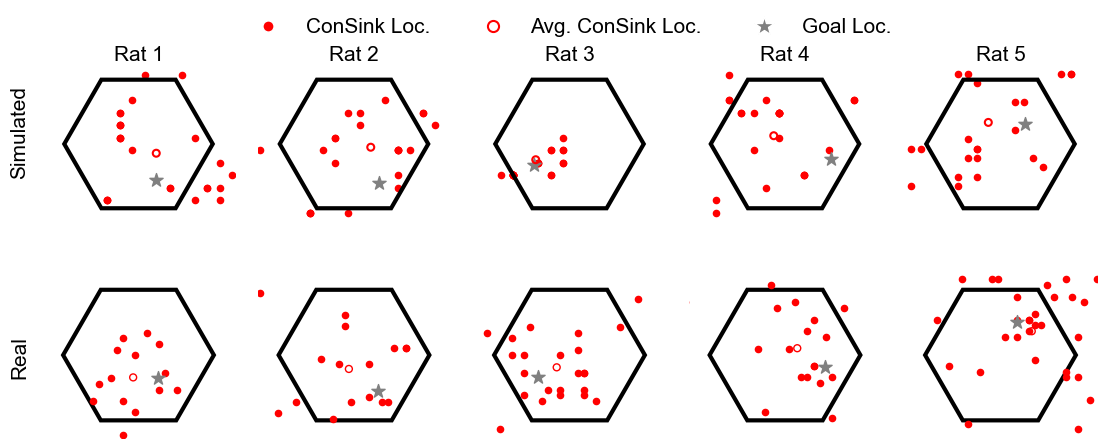

In [7]:
fontsize = 15
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': fontsize,
    'axes.linewidth': 0.5,
    'axes.labelsize': fontsize,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5
})

fig, ax = plt.subplots(2, 5, figsize=(11, 5))
for i, rat_id in enumerate([3, 7, 8, 9, 10]):
    print(rat_id)
    session = rat_session[rat_id]
    BASEDIR = "/Users/changminyu/Desktop/research/data/Jake_all_rats/"

    # pos_mat_logdir = "/home/zilong/Desktop/HoneycombSweeps/realtrajs/rat_"+str(rat_id)+"_positionalDataByTrialType.mat"
    # running_gaps_logdir = "/home/zilong/Desktop/HoneycombSweeps/realtrajs/rat_"+str(rat_id)+"_runningGaps.mat"
    pos_mat_logdir = os.path.join(BASEDIR, f"Rat{rat_id}", session, "positionalData", "positionalDataByTrialType.mat")
    running_gaps_logdir = os.path.join(BASEDIR, f"Rat{rat_id}", session, "physiologyData", "runningGaps.mat")

    if rat_id == 9:
        behavioural_data = get_behavioural_data(pos_mat_logdir, running_gaps_logdir, T=4000000)
    else:
        behavioural_data = get_behavioural_data(pos_mat_logdir, running_gaps_logdir)


    Animal_location_all = behavioural_data["pos"]
    MV_direction_all = behavioural_data["md"]
    Animal_speed_all = behavioural_data["speed"]
    Dir2Goal_all = behavioural_data["Dir2Goal"]
    Head_direction_all = behavioural_data["hd"]
    goal_loc = behavioural_data["goal_location"]
    Animal_Vel_all = behavioural_data["velocity"]
    Rotation_direction_all = behavioural_data["rotation_direction"]
    
    (Best_Sinks_activeScan, Best_MRLs_activeScan) = pickle.load(
        open("logs/ConSink_real_traj_rat_"+str(rat_id)+".pkl", "rb")
    )
    
    Best_Sinks_activeScan = np.array(Best_Sinks_activeScan)
    Best_MRLs_activeScan = np.array(Best_MRLs_activeScan)

    print('Max MRL', np.mean(Best_MRLs_activeScan))

    for j, sink in enumerate(Best_Sinks_activeScan):
        if j == 0:
            ax[0, i].scatter(sink[0], sink[1], color='red', marker='o', s=20, label='ConSinks')
        else:
            ax[0, i].scatter(sink[0], sink[1], color='red', marker='o', s=20)

    ax[0, i].scatter(goal_loc[0], goal_loc[1], color='gray', marker='*', s=100, label='Goal')

    # Compute and plot mean best sink (blue star)
    mean_sink = np.mean(np.vstack(Best_Sinks_activeScan), axis=0)
    ax[0, i].scatter(mean_sink[0], mean_sink[1], facecolors='none', edgecolors='red', marker='o', s=25, linewidth=1.5, label='Mean sink loc.')


    #mark the box from -0.5*np.pi to 0.5*np.pi along x and y
    # box_x = [-0.5 * np.pi, 0.5 * np.pi, 0.5 * np.pi, -0.5 * np.pi, -0.5 * np.pi]
    # box_y = [-0.5 * np.pi, -0.5 * np.pi, 0.5 * np.pi, 0.5 * np.pi, -0.5 * np.pi]
    # ax0.plot(box_x, box_y, color='black', linewidth=0.5, linestyle='--', label='Env boundaries')


    hexagon_vertices_and_plot(
        ax[0, i], 
        center=np.array([0, 0]),
        left_vertex=np.array([-0.5 * np.pi, 0]),
        linewidth=3.0, 
    )
    
    spikes_mrl_log_dir = os.path.join(BASEDIR, f"Rat{rat_id}", session, "physiologyData", "direction", "mrlFocus_spikes_coarse.mat")
    pos_mat_log_dir = os.path.join(BASEDIR, f"Rat{rat_id}", session, "positionalData", "positionalDataByTrialType.mat")
    d_pos = load_pos_mat(pos_mat_log_dir)
    d_spikes_mrl = load_spikes_mrl_mat(spikes_mrl_log_dir)
    goal_location = d_pos["goalPosition"][0][0][0]
    
    hexagon_vertices_and_plot(
        ax[1, i], 
        center=np.array([40, 32]), 
        left_vertex=np.array([10, 32]), 
        linewidth=3.0, 
        edgecolor="black", 
        alpha=1.0
    )
    all_consink_locs = np.concatenate([
        d_spikes_mrl["spikes_mrl"][cell_id]["hComb"]["norm"]["coor"] for cell_id in d_spikes_mrl["significant_cells_norm"]["hComb"]
    ], axis=0)
    frame_size = d_pos["frameSize"]
    consink_loc = all_consink_locs / np.array([[frame_size[0]/80, frame_size[1]/64]])
    mean_sink_loc = np.mean(consink_loc, axis=0)
    ax[1, i].scatter(consink_loc[:, 0], consink_loc[:, 1], color="red", s=20, zorder=1)
    ax[1, i].scatter(mean_sink_loc[0], mean_sink_loc[1], color="red", s=25, marker="o", facecolors='none', zorder=2)

    goal_location_binned = goal_location / (496 / 80)
    goal_location_binned[1] = goal_location_binned[1]
    ax[1, i].scatter(goal_location_binned[0], goal_location_binned[1], c="gray", s=100, marker="*", zorder=10)
    ax[1, i].set_xlim(0+80*0.02, 80-80*0.02)
    ax[1, i].set_ylim(0-1, 64+1)

for i in range(2):
    for j in range(5):
        # ax_i.legend(fontsize=15, loc='center left', bbox_to_anchor=(0.75, 0.5), frameon=False)

        if i == 0:
            ax[i, j].set_xlim(-0.65*np.pi, 0.65*np.pi)
            ax[i, j].set_ylim(-0.5*np.pi, 0.5*np.pi)
        ax[i, j].set_aspect('equal')
        #ticks off
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        ax[i, j].axis("off")
        
        if i == 0:
            ax[i, j].set_title(f'Rat {j+1}', fontsize=fontsize)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='ConSink Loc.'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='red', 
           markeredgewidth=1.5, markersize=8, label='Avg. ConSink Loc.'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Goal Loc.')
]

fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.0), 
           frameon=False, fontsize=fontsize)

fig.text(0.0, 0.25, "Real", fontsize=fontsize, ha='center', rotation=90)
fig.text(0.0, 0.65, "Simulated", fontsize=fontsize, ha='center', rotation=90)

plt.tight_layout()

fig.savefig("figures/PaperFig/ConSinkLoc_all_rats_real_traj_and_real_consinks.pdf", bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [35]:
j

24